In [1]:
# See basic_regressions.ipynb for data visualizations

In [2]:
import pandas as pd
import os
import pystan
import matplotlib.pyplot as plt
import pickle

In [3]:
df = pd.concat(pd.read_csv(os.path.join('data', filename), index_col=0) for filename in os.listdir('data') if filename.endswith('.csv'))

# change data type on a couple of variables
df['explicit'] = df['explicit'].astype('int')
df['release_date'] = pd.to_datetime(df['release_date'], yearfirst=True)


# Modify some variables so they make more sense in regression context

# is 4:4?
df['time_signature_4'] = (df['time_signature'] == 4).astype('int')
# difference between data collection date and release date
df['days_since_release'] = (pd.to_datetime('2020-03-11') - df['release_date']).apply(lambda x: x.days)
# Express durations in seconds, not milliseconds
df['duration_s'] = df['duration_ms']*1000

# drop messed up entries
df.dropna(inplace=True)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


## Linear regression for variables that affect popularity

In [21]:
features = ['availability', 'explicit', 'track_number', 'days_since_release', 'num_artists', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s', 'time_signature_4']

In [34]:
model_str = '''
data {
    int<lower=0> N; // number of songs in the data set
    int<lower=0> K; // number of regression vars
    vector[N] y; // dependent variable
    matrix[N, K] X; // independent variables
}

transformed data {
    vector[K] X_means;
    vector[K] X_stdevs;
    matrix[N, K] X_std;
    matrix[N, K] Q_star;
    matrix[K, K] R_star;
    matrix[K, K] R_star_inverse;
    // standardize the features
    for (k in 1:K) {
        X_means[k] = mean(X[,k]);
        X_stdevs[k] = sd(X[,k]);
        X_std[,k] = (X[,k] - X_means[k]) / X_stdevs[k];
    }
    // get QR decomposition
    // thin and scale the QR decomposition
    Q_star = qr_thin_Q(X_std) * sqrt(N - 1);
    R_star = qr_thin_R(X_std) / sqrt(N - 1);
}

parameters {
    real alpha; // the intercept
    vector[K] theta; // the coeffs on Q_star
    real<lower=0> sigma_raw; // st dev of error
    real<lower=0> nu; // degrees of freedom
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sigma_raw * sqrt((nu - 2) / nu);
}

model {
    // priors
    alpha ~ normal(mean(y), 10);
    theta ~ normal(0, 1000);
    sigma_raw ~ cauchy(0, 5);
    nu ~ gamma(2, 0.1);
    // likelihood
    y ~ student_t(nu, alpha + Q_star * theta, sigma);
}

generated quantities {
    vector[K] beta_std; // standardized coeffs on X
    vector[K] beta; // the coeffs on X
    beta_std = R_star \ theta;
    for (k in 1:K) {
        beta[k] = beta_std[k] / X_stdevs[k];
    }
}
'''


y = df['popularity'].values
X = df[features].values

data = {
    'N': X.shape[0],
    'K': X.shape[1],
    'y': y,
    'X': X
}

if os.path.isfile('model.pkl'):
    with open('model.pkl', 'rb') as fh:
        model = pickle.load(fh)
else:
    model = pystan.StanModel(model_code=model_str)
    with open('model.pkl', 'wb') as fh:
        pickle.dump(model, fh)
print('[[compiled / read model]]')

fit = model.sampling(data=data, iter=10000, warmup=1000, chains=2)  # takes about 20 minutes on my laptop

[[compiled / read model]]


In [39]:
with open('fit.pkl', 'wb') as fh:
    pickle.dump(fit, fh)

/home/mckay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


In [36]:
print(fit.stansummary())

Inference for Stan model: anon_model_0dc93036e7c029618cf7e5b0ef0f8f66.
2 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=18000.

                mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
alpha          26.04  3.5e-4    0.07   25.89   25.99   26.04   26.09   26.18  43297    1.0
theta[1]        9.62  3.6e-4    0.07    9.48    9.57    9.62    9.67    9.76  39821    1.0
theta[2]        5.57  3.2e-4    0.07    5.43    5.53    5.57    5.62    5.71  49884    1.0
theta[3]       -4.95  3.5e-4    0.07   -5.09    -5.0   -4.95    -4.9   -4.81  43318    1.0
theta[4]        -3.1  3.3e-4    0.07   -3.24   -3.15    -3.1   -3.06   -2.97  45146    1.0
theta[5]       -0.47  3.4e-4    0.07   -0.61   -0.51   -0.47   -0.42   -0.33  43411    1.0
theta[6]         2.0  3.5e-4    0.07    1.86    1.96     2.0    2.05    2.14  40368    1.0
theta[7]        2.84  3.5e-4    0.07     2.7    2.79    2.84    2.89    2.98  422

In [25]:
def make_plots(fit_obj):
    fit_df = fit_obj.to_dataframe().set_index('draw')
    for param in [c for c in fit_df.columns if c not in ('chain', 'draw', 'warmup')]:
        fit_df.groupby('chain')[param].plot(alpha=0.7, legend=True, title=param)
        plt.show()
        fit_df.groupby('chain')[param].plot.hist(alpha=0.7, bins=50, legend=True, title=param)
        plt.show()

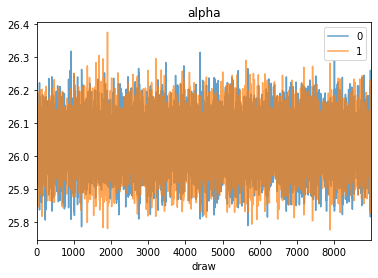

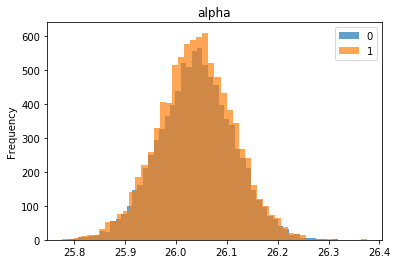

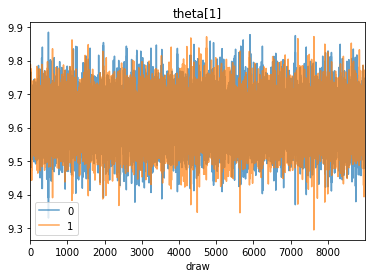

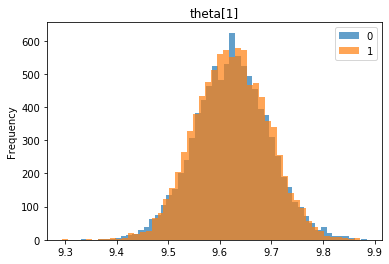

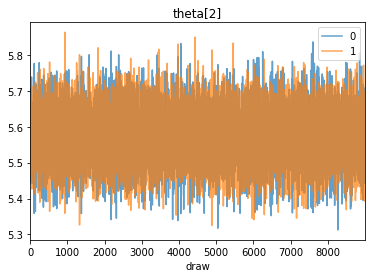

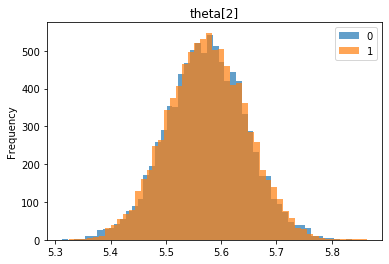

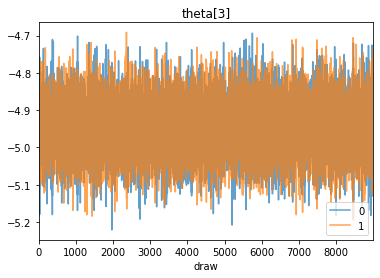

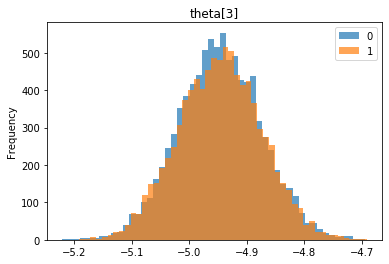

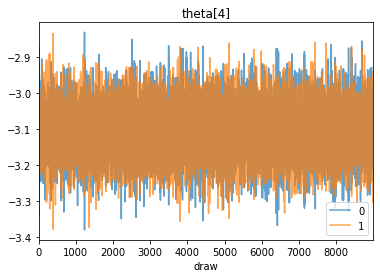

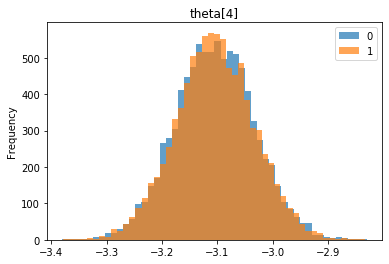

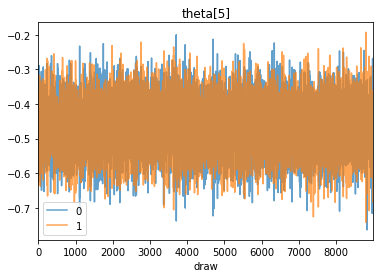

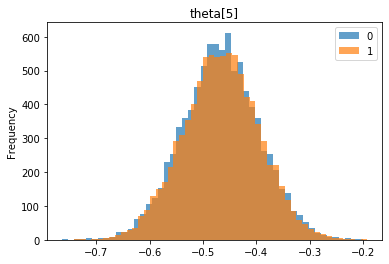

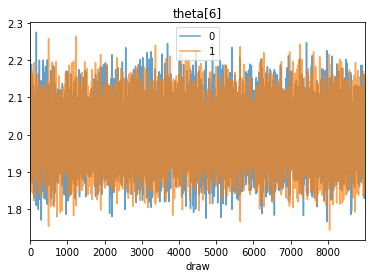

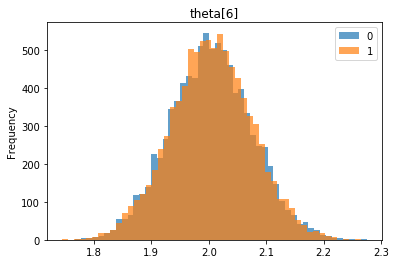

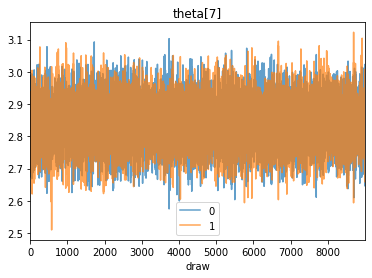

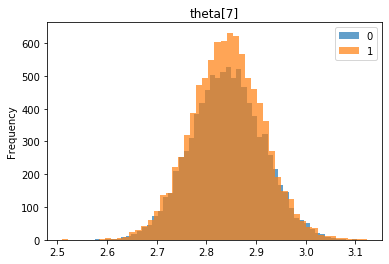

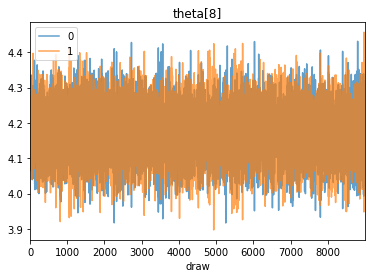

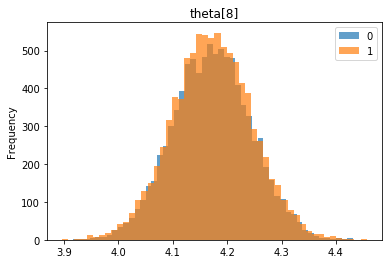

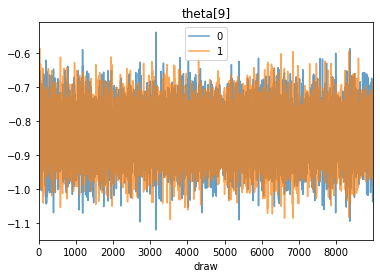

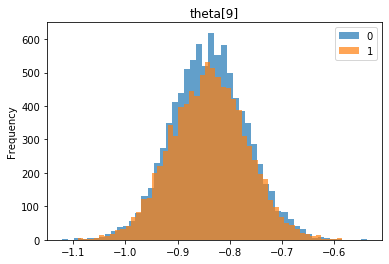

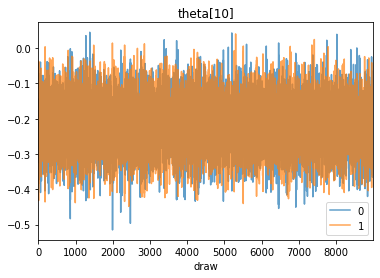

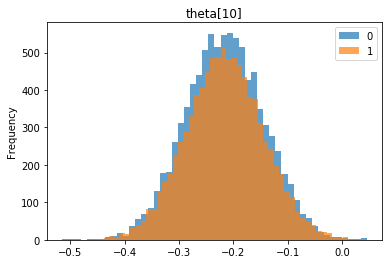

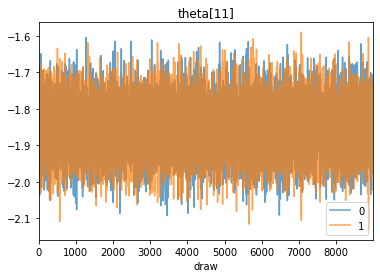

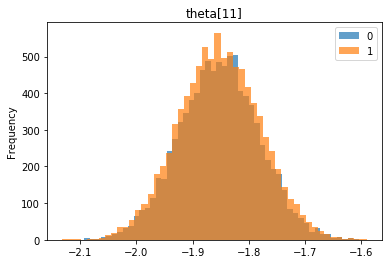

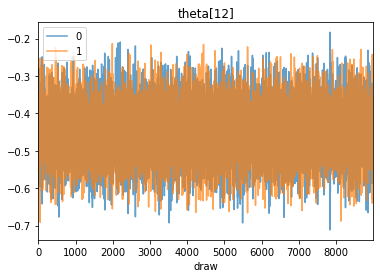

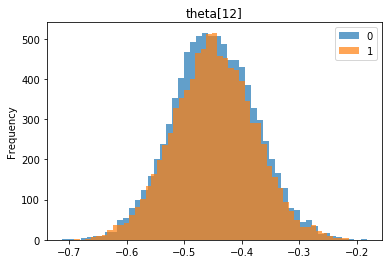

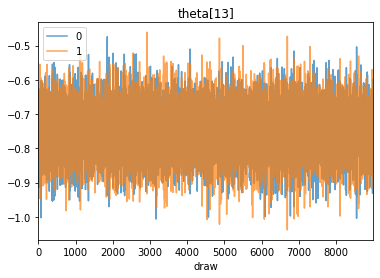

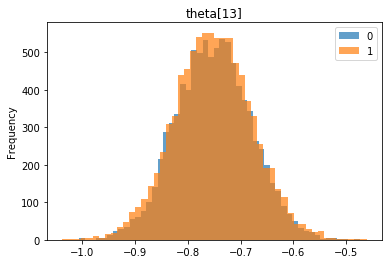

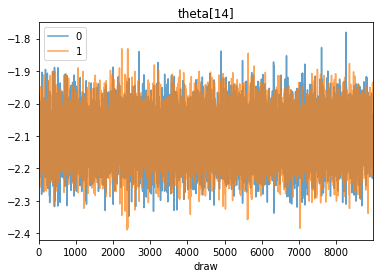

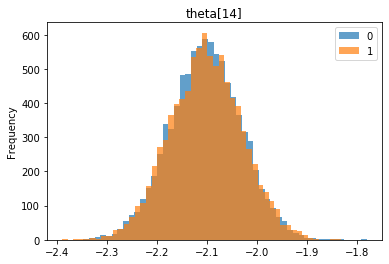

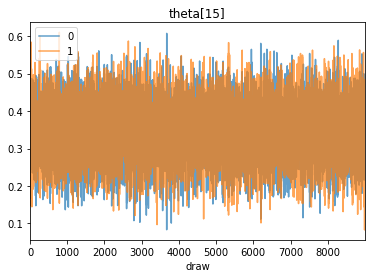

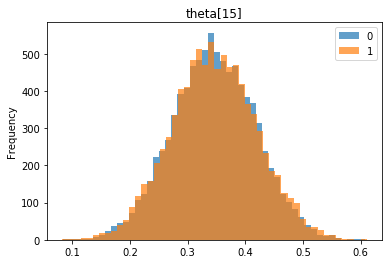

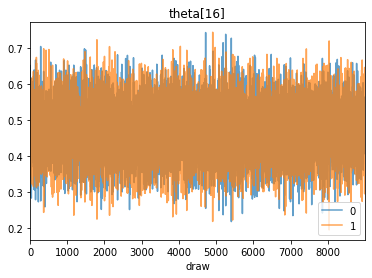

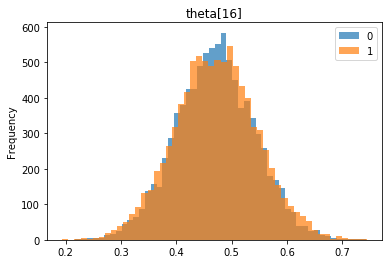

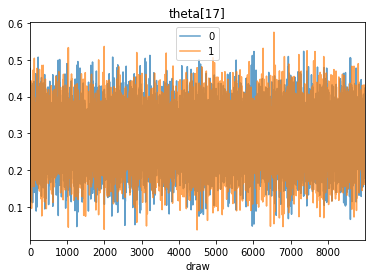

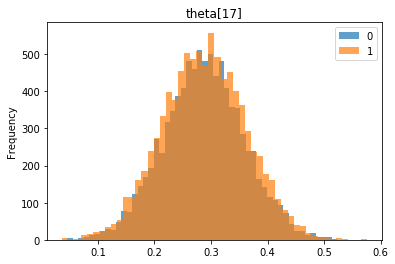

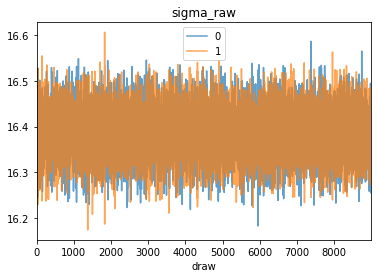

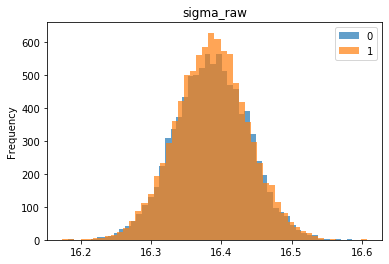

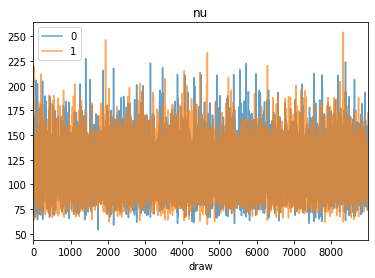

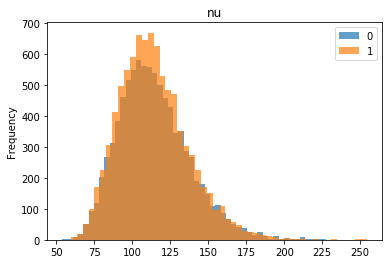

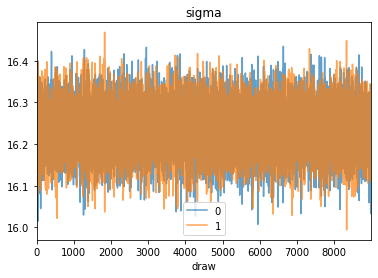

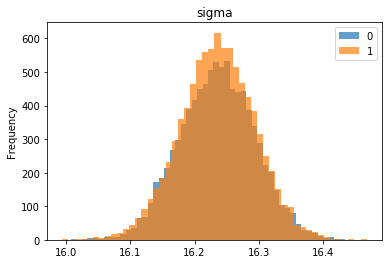

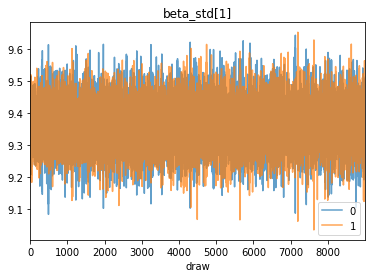

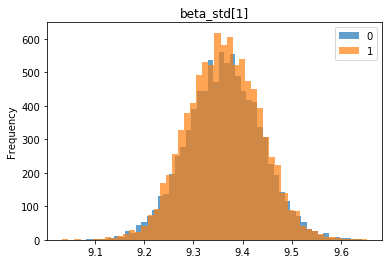

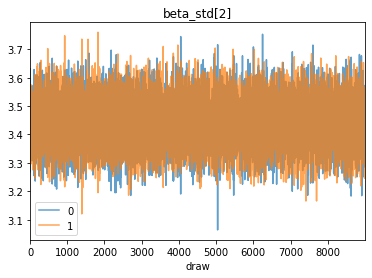

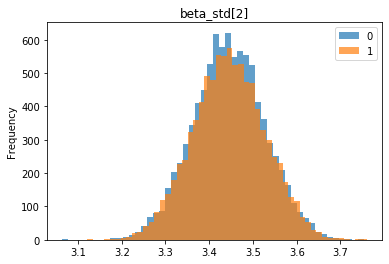

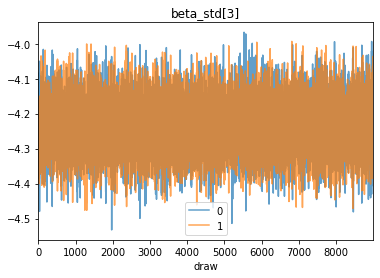

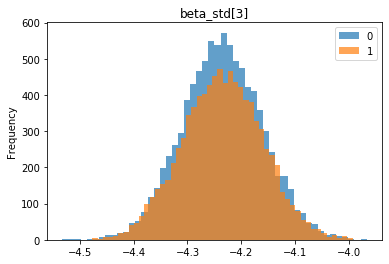

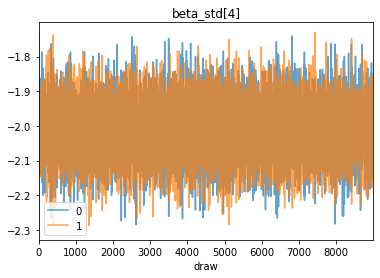

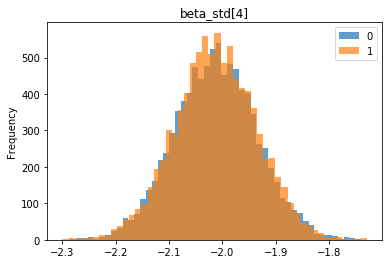

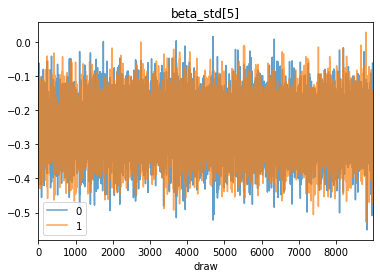

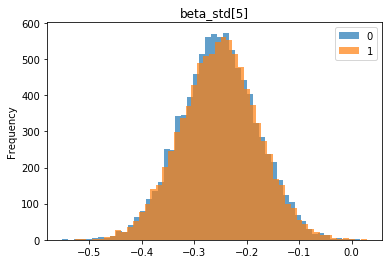

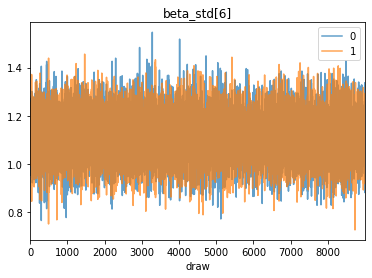

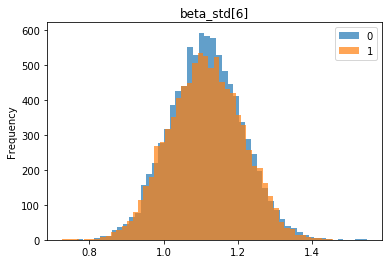

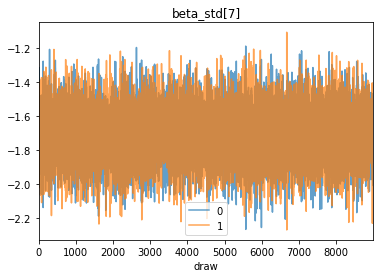

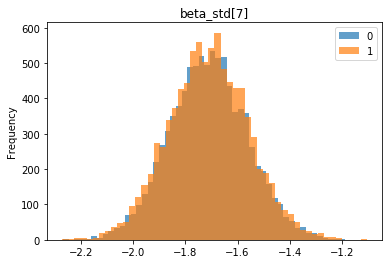

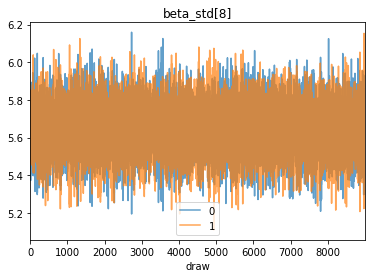

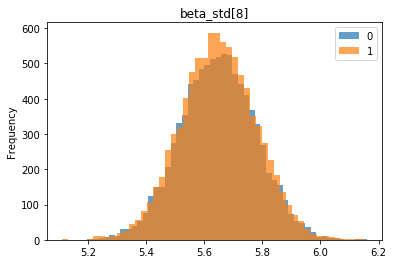

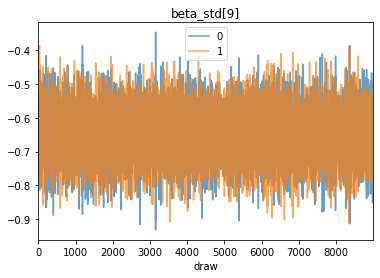

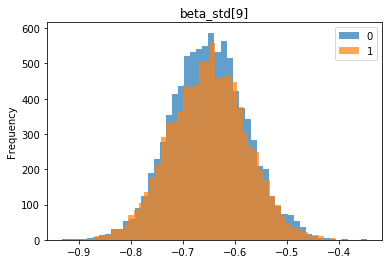

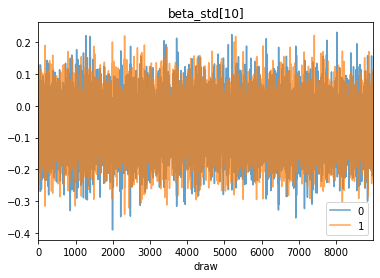

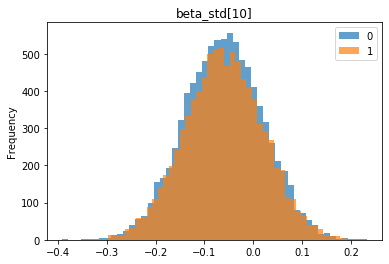

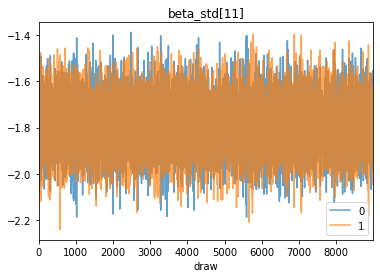

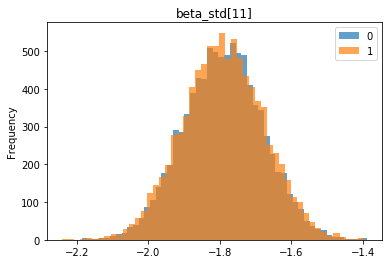

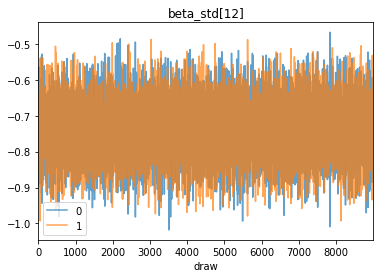

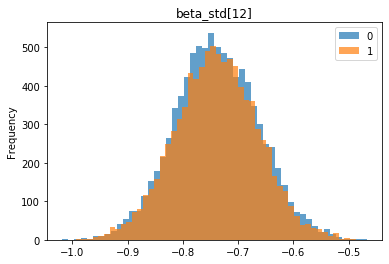

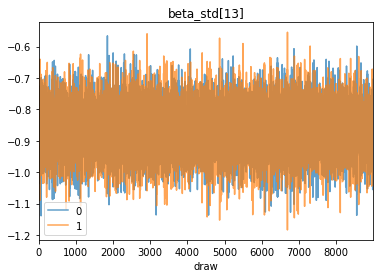

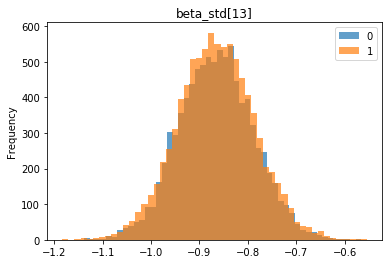

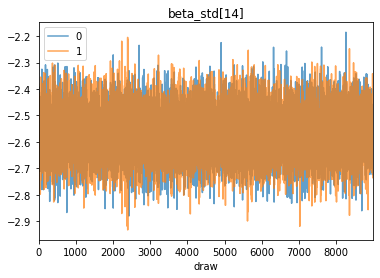

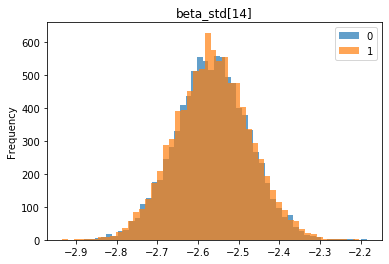

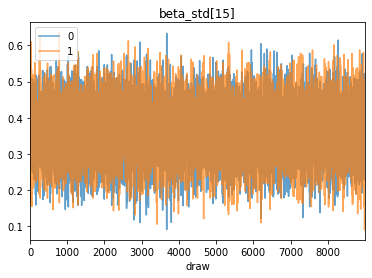

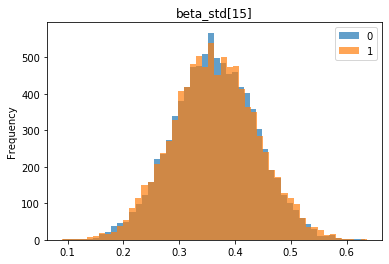

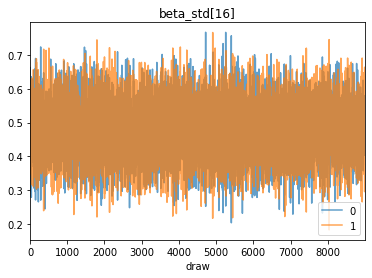

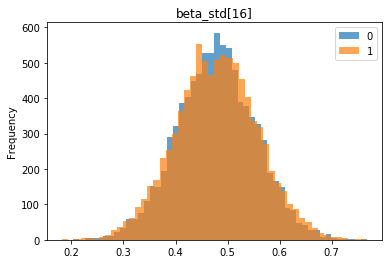

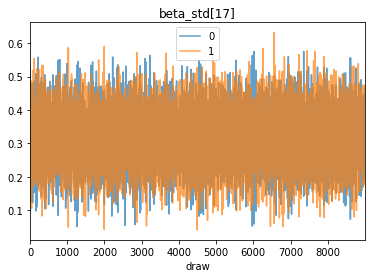

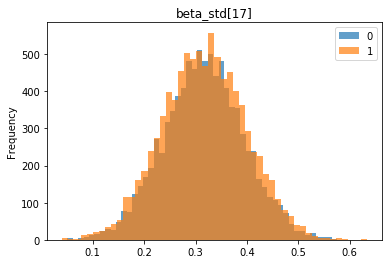

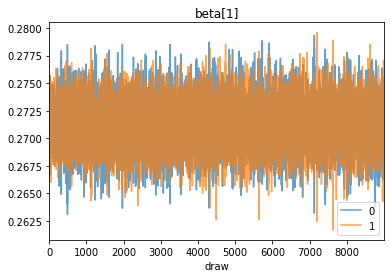

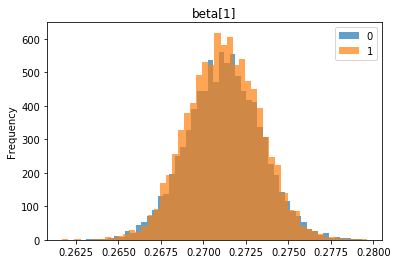

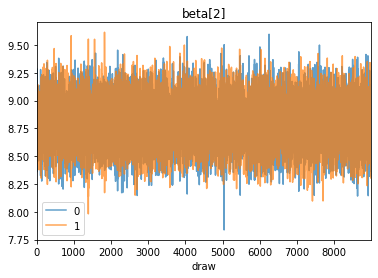

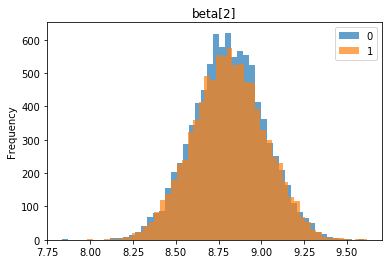

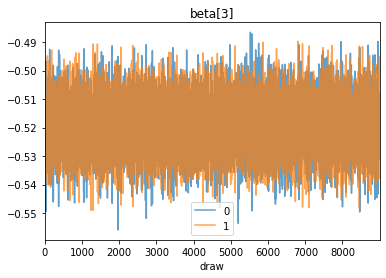

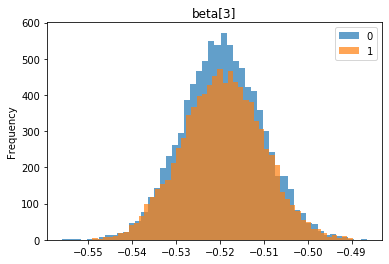

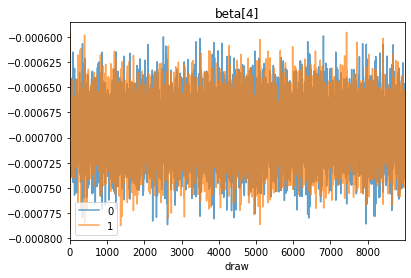

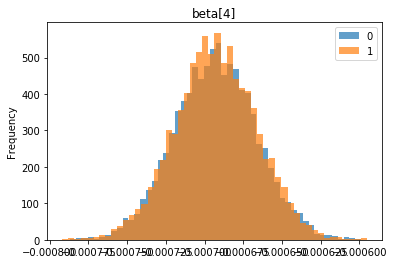

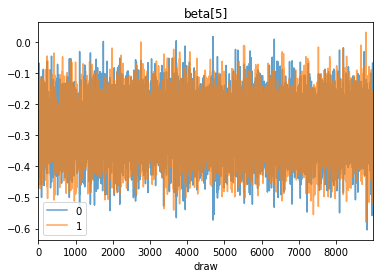

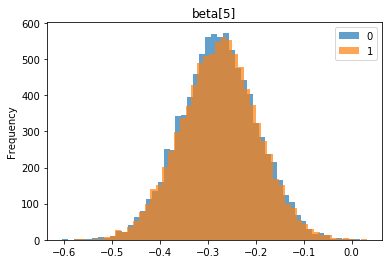

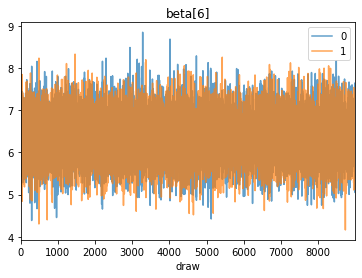

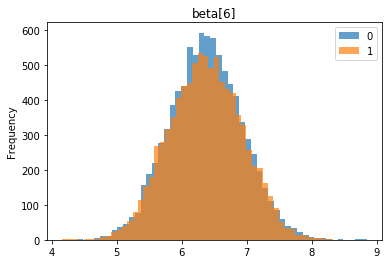

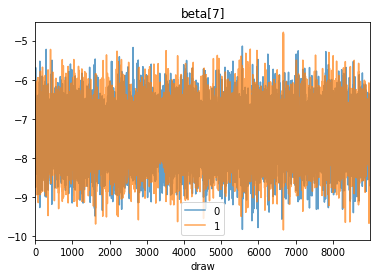

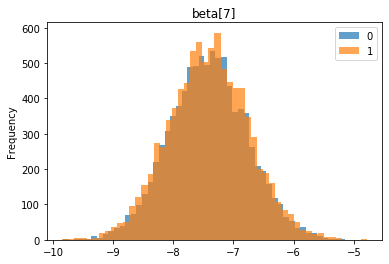

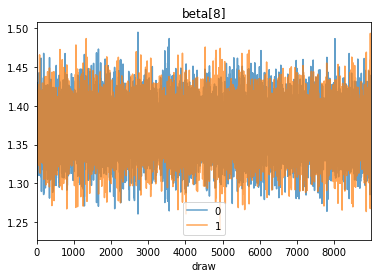

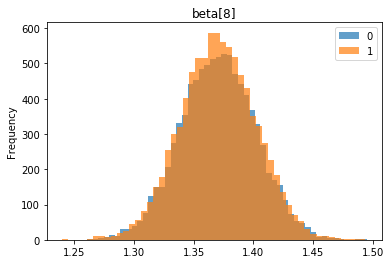

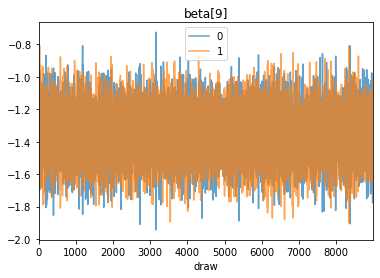

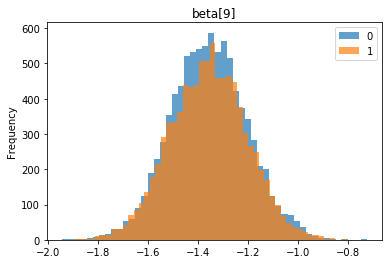

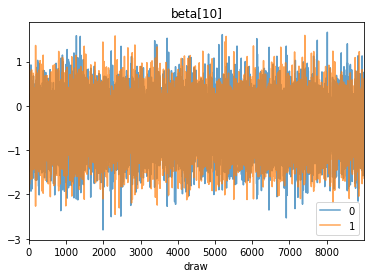

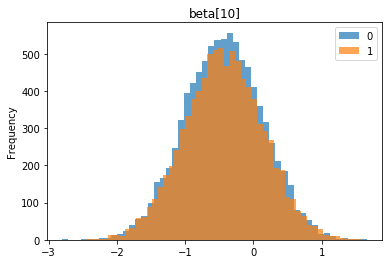

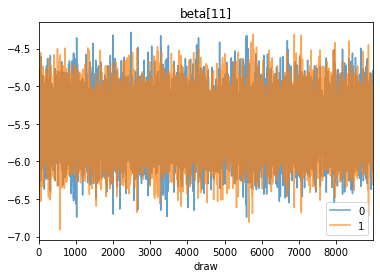

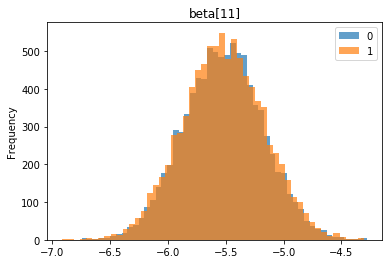

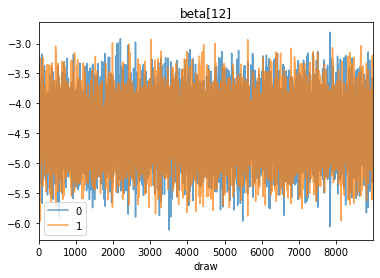

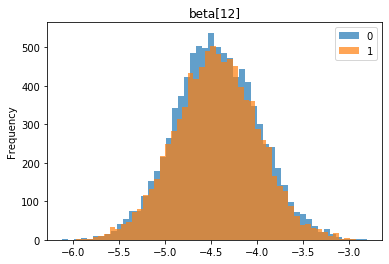

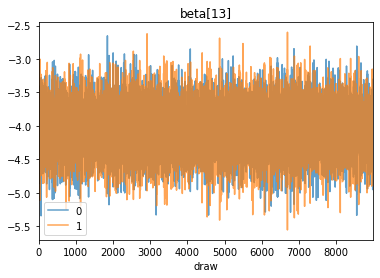

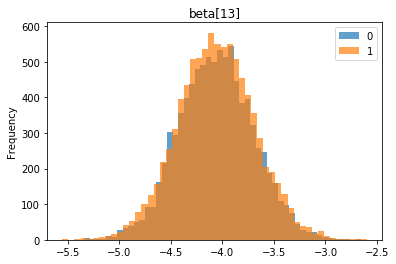

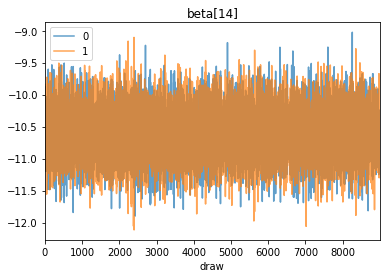

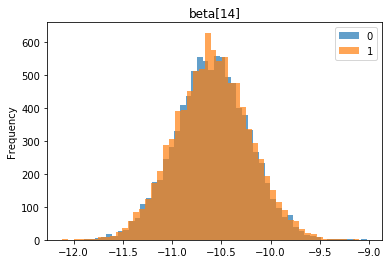

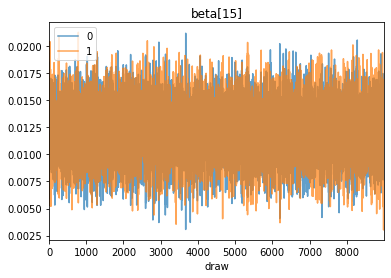

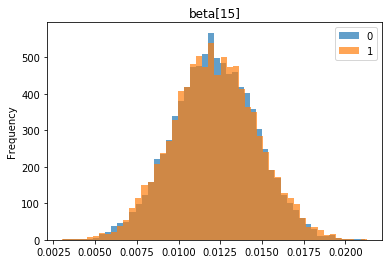

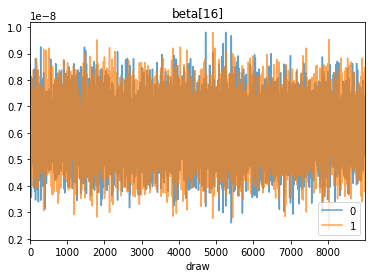

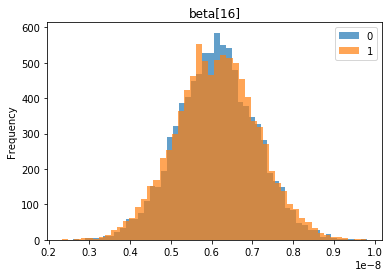

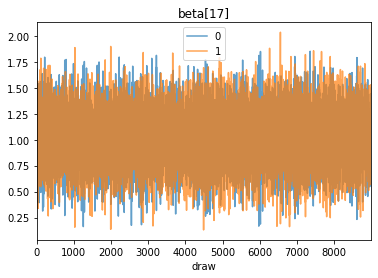

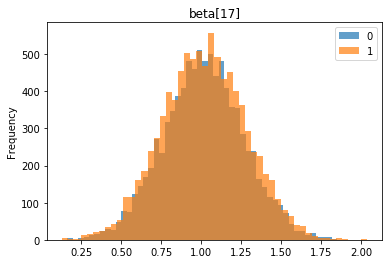

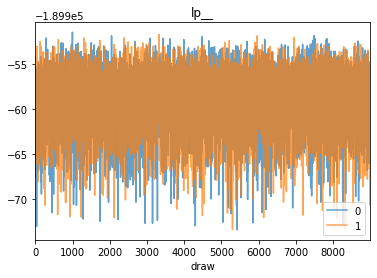

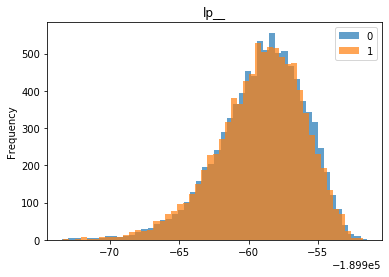

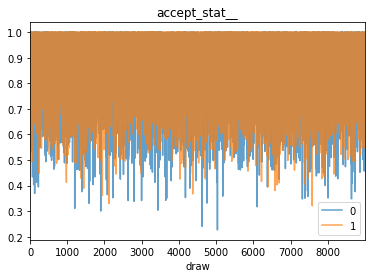

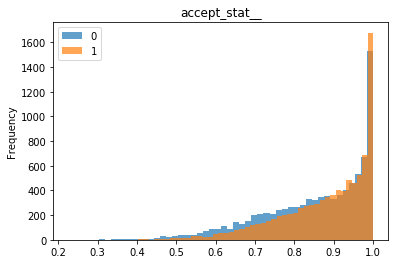

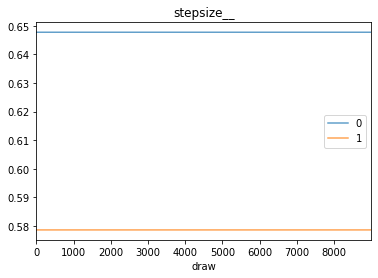

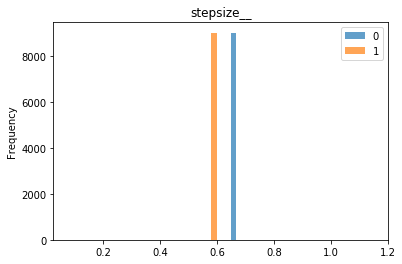

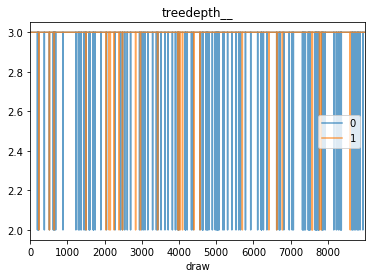

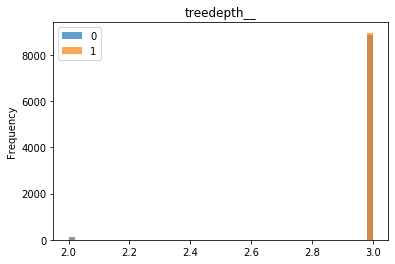

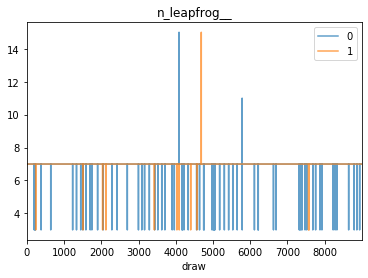

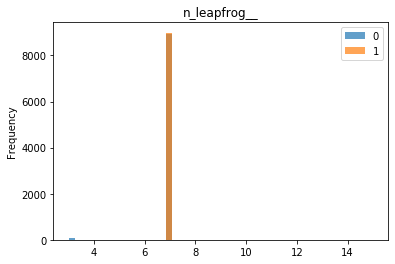

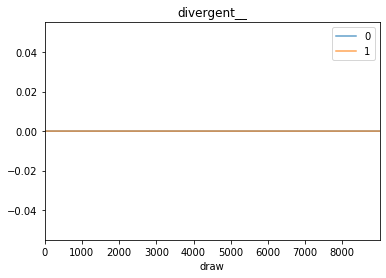

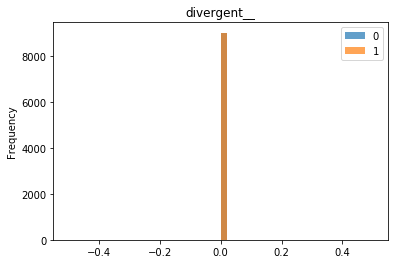

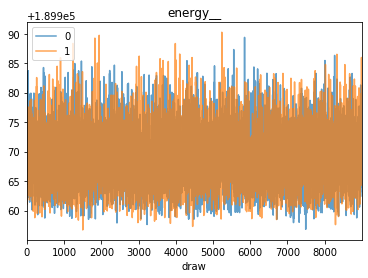

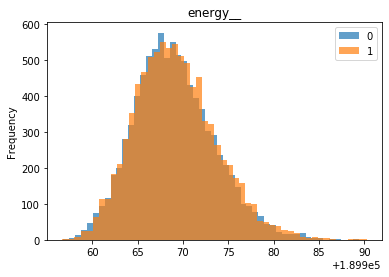

In [35]:
make_plots(fit)

## Logistic regression for predicting what songs I like

In [5]:
# load data for my songs

mydf = pd.concat(pd.read_csv(os.path.join('data', 'my_data', filename), index_col=0) for filename in os.listdir('data/my_data'))

# change data type on a couple of variables
mydf['explicit'] = mydf['explicit'].astype('int')
mydf['release_date'] = pd.to_datetime(mydf['release_date'], yearfirst=True)


# Modify some variables so they make more sense in regression context

# is 4:4?
mydf['time_signature_4'] = (mydf['time_signature'] == 4).astype('int')
# difference between data collection date and release date
mydf['days_since_release'] = (pd.to_datetime('2020-03-11') - mydf['release_date']).apply(lambda x: x.days)
# Express durations in seconds, not milliseconds
mydf['duration_s'] = mydf['duration_ms']*1000

# drop messed up entries
mydf.dropna(inplace=True)

In [13]:
# take a random sample of the other data set to keep computation manageable & sample sizes mostly balanced
df_sample = df.sample(2000, random_state=152)

# assign labels
mydf['is_favorite'] = 1
df_sample['is_favorite'] = 0

# combine into 1 df
combined_df = pd.concat((mydf, df_sample))
combined_df = combined_df[~combined_df.index.duplicated(keep='first')]

In [17]:
# create logistic regression in stan

logit_model_str = '''
data {
  int<lower=0> N;
  int<lower=0> K;
  matrix[N, K] X;
  int<lower=0,upper=1> y[N];
}

transformed data {
  // standardarize each feature
  vector[K] X_means;
  vector[K] X_stdevs;
  matrix[N, K] X_std;
  for (k in 1:K) {
    X_means[k] = mean(X[,k]);
    X_stdevs[k] = sd(X[,k]);
    X_std[,k] = (X[,k] - X_means[k]) / X_stdevs[k];
  }
}

parameters {
  real alpha;
  vector[K] beta_std;
}

model {
  // likelihood
  y ~ bernoulli_logit(alpha + X_std * beta_std);
}

generated quantities {
  vector[K] beta;
  for (k in 1:K) {
    beta[k] = beta_std[k] / X_stdevs[k];
  }
}
'''

logit_features = features + ['popularity']
y = combined_df['is_favorite'].values
X = combined_df[logit_features].values

logit_data = {
    'N': X.shape[0],
    'K': X.shape[1],
    'X': X,
    'y': y
}

if os.path.isfile('logit_model.pkl'):
    with open('logit_model.pkl', 'rb') as fh:
        logit_model = pickle.load(fh)
else:
    logit_model = pystan.StanModel(model_code=logit_model_str)
    with open('logit_model.pkl', 'wb') as fh:
        pickle.dump(logit_model, fh)
print('[[compiled / read model]]')

logit_fit = logit_model.sampling(data=logit_data, iter=10000, warmup=1000, chains=2)

[[compiled / read model]]


In [38]:
with open('logit_fit.pkl', 'wb') as fh:
    pickle.dump(logit_fit, fh)

/home/mckay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


In [37]:
print(logit_fit.stansummary())

Inference for Stan model: anon_model_04131dd70d4d457c0ddaefb4b3c93810.
2 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=18000.

                mean se_mean     sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
alpha          -4.18  1.5e-3   0.21   -4.61   -4.32   -4.18   -4.04   -3.79  19546    1.0
beta_std[1]     0.25  7.3e-4   0.13    0.01    0.17    0.25    0.34     0.5  29863    1.0
beta_std[2]    -1.06  1.2e-3    0.2   -1.47   -1.18   -1.05   -0.92    -0.7  27318    1.0
beta_std[3]    -1.64  1.3e-3   0.21   -2.06   -1.78   -1.63   -1.49   -1.24  25660    1.0
beta_std[4]    -0.52  7.9e-4   0.13    -0.8   -0.61   -0.52   -0.43   -0.28  28408    1.0
beta_std[5]     -0.5  7.9e-4   0.13   -0.77   -0.59    -0.5   -0.41   -0.25  27972    1.0
beta_std[6]     0.43  8.8e-4   0.14    0.16    0.34    0.43    0.52     0.7  23662    1.0
beta_std[7]     0.36  1.4e-3    0.2   -0.02    0.23    0.36     0.5    0.75  18656    1.0

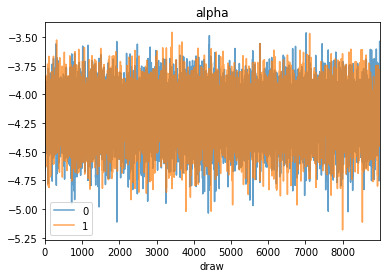

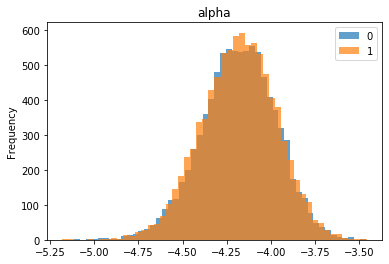

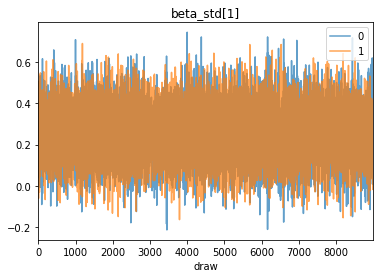

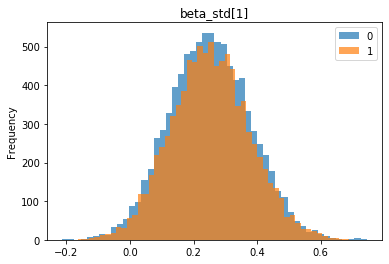

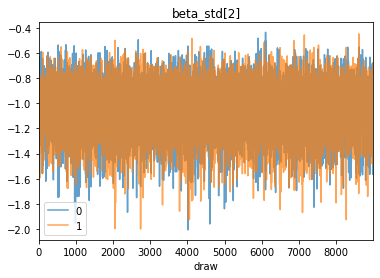

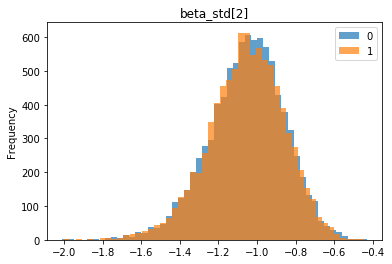

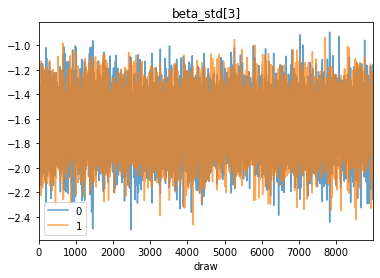

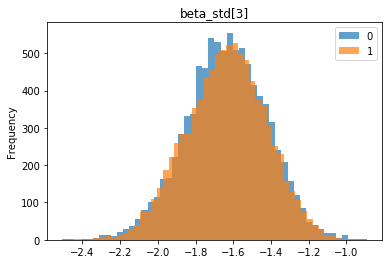

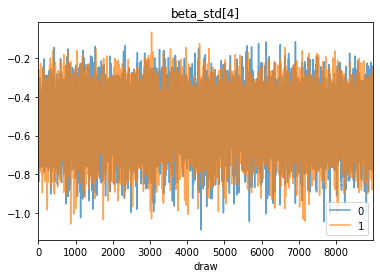

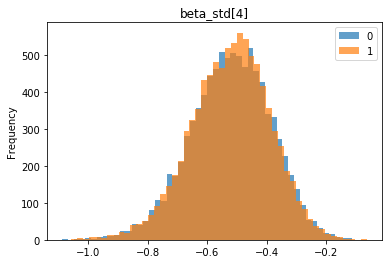

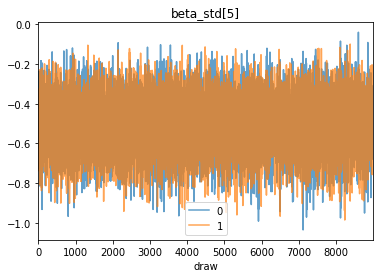

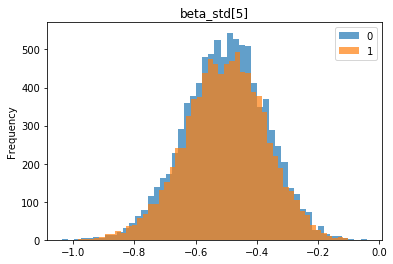

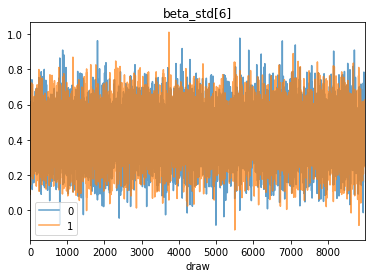

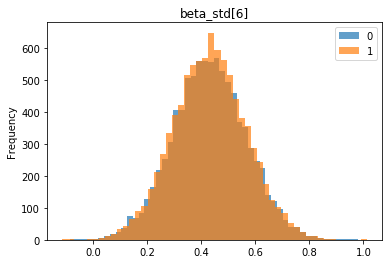

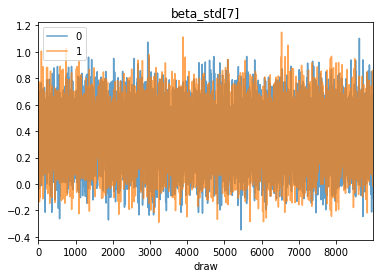

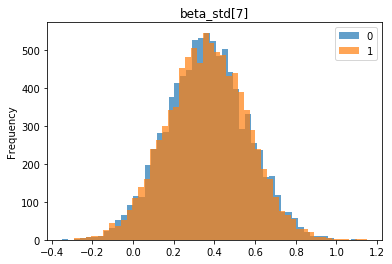

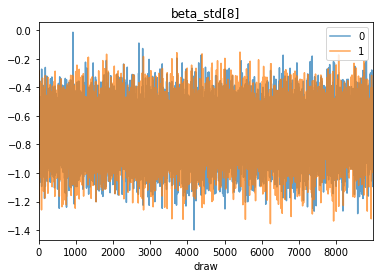

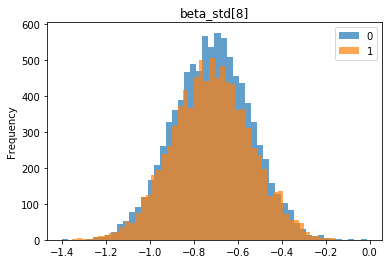

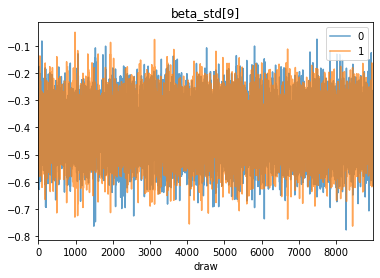

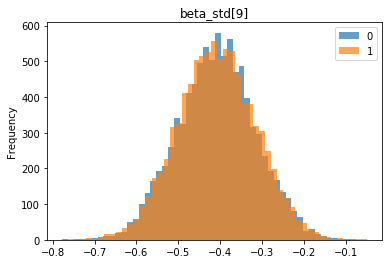

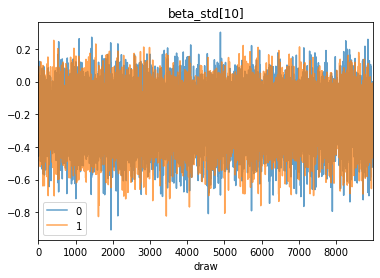

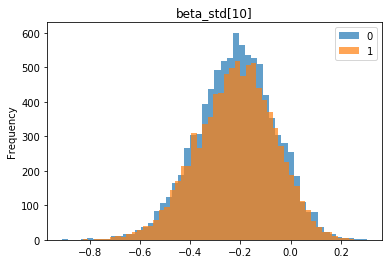

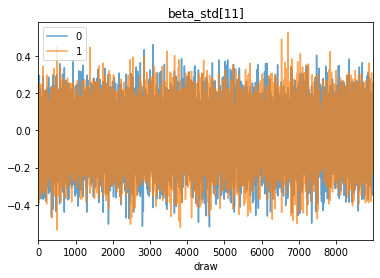

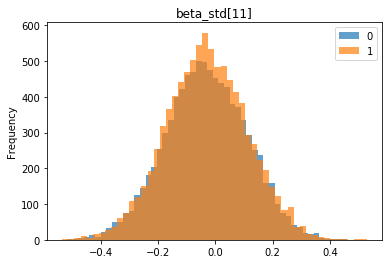

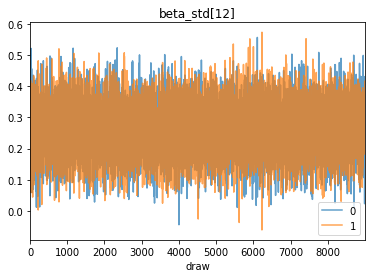

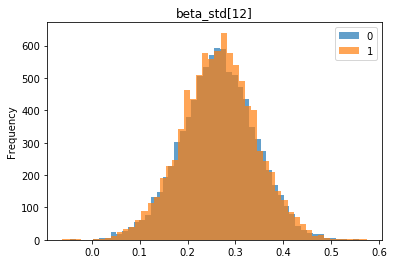

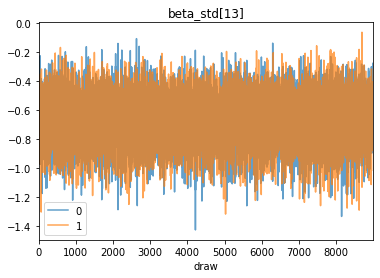

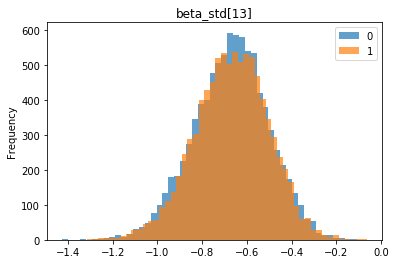

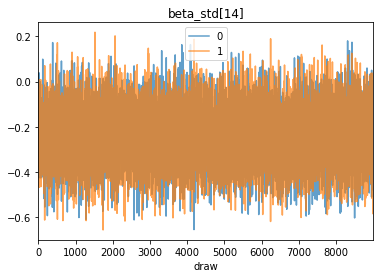

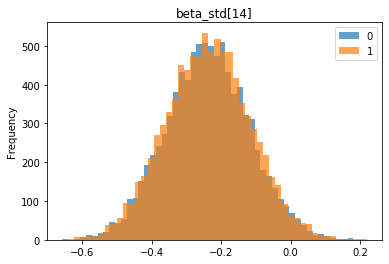

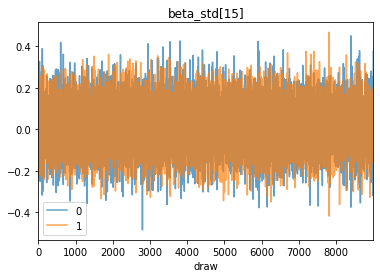

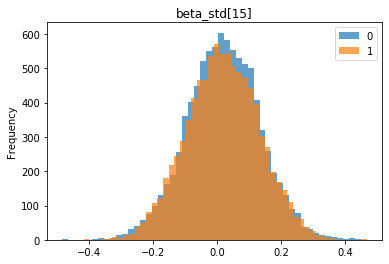

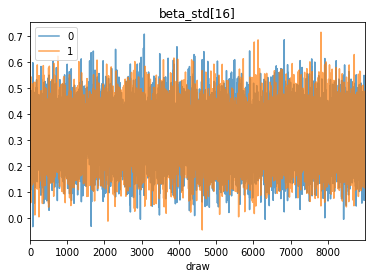

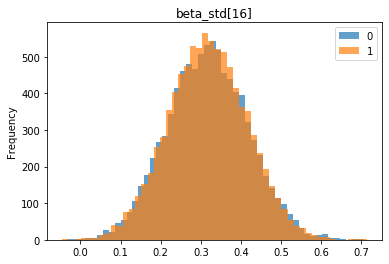

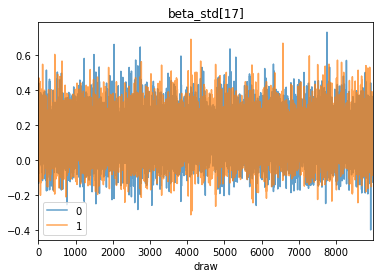

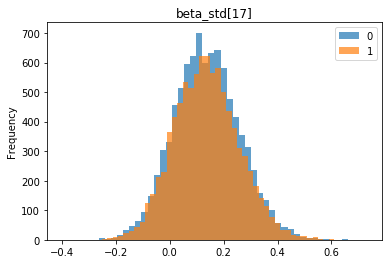

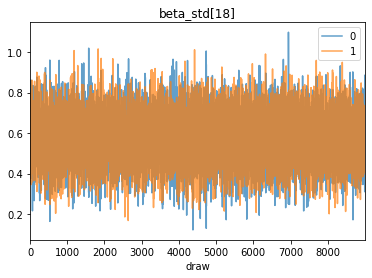

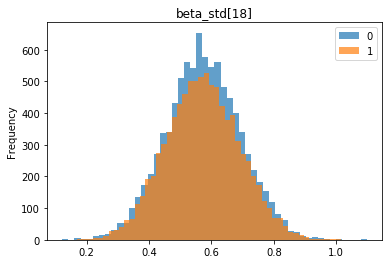

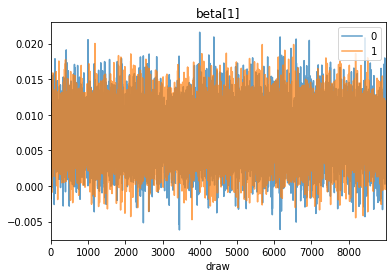

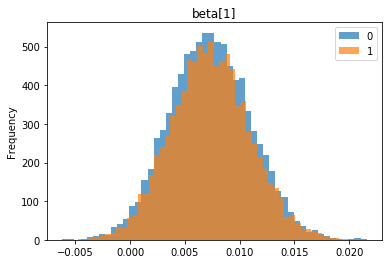

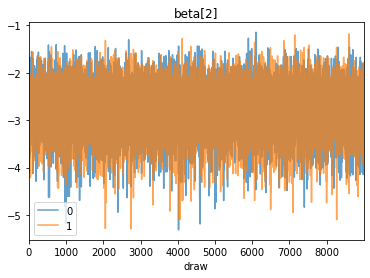

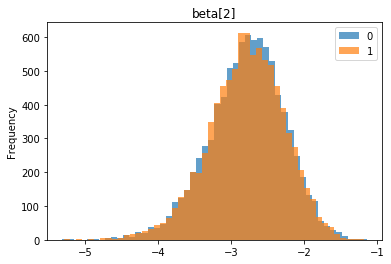

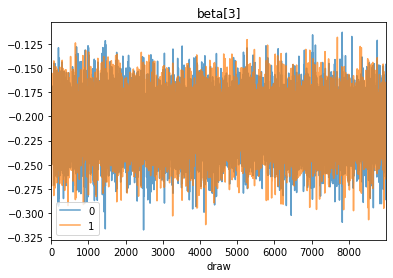

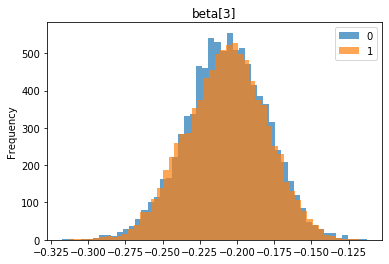

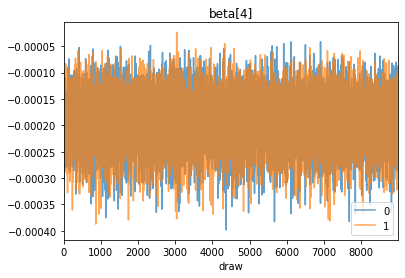

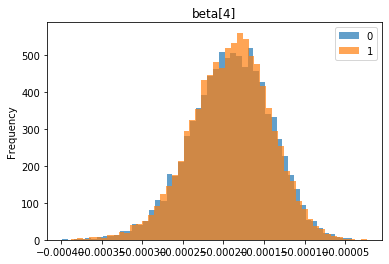

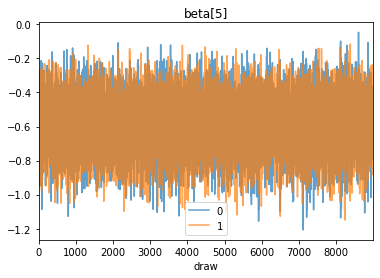

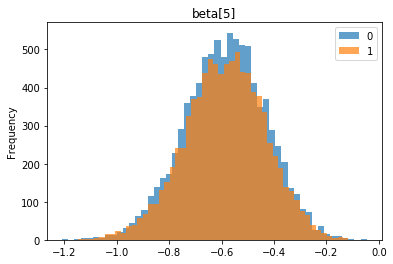

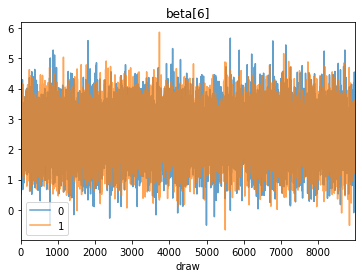

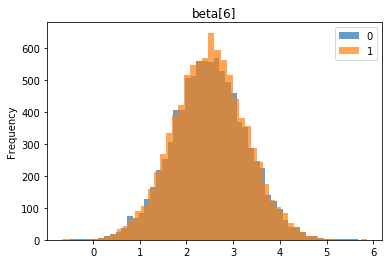

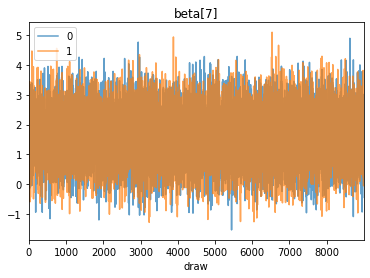

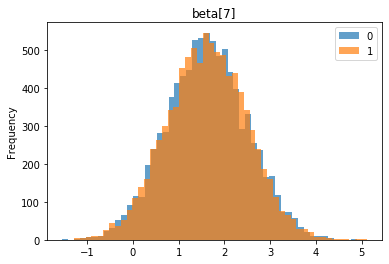

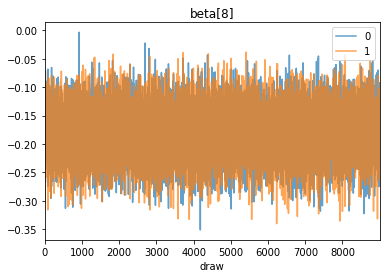

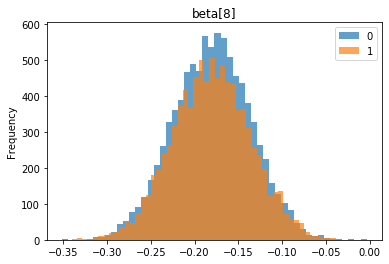

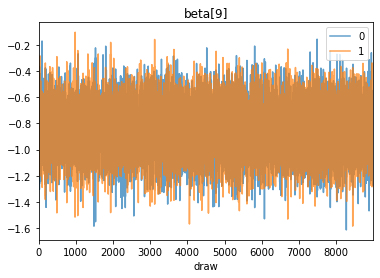

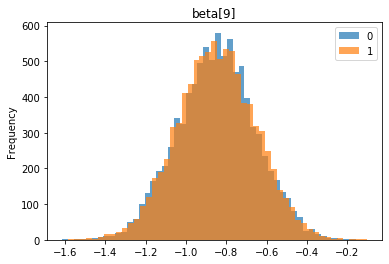

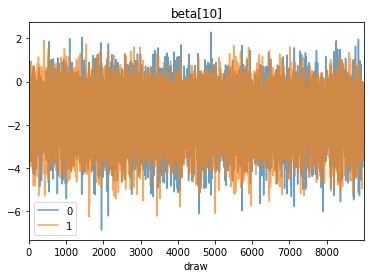

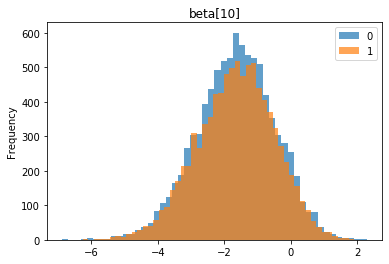

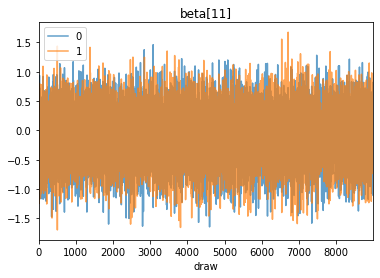

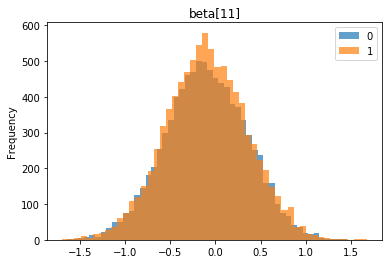

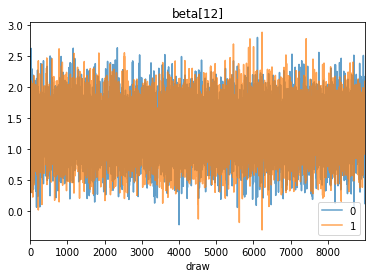

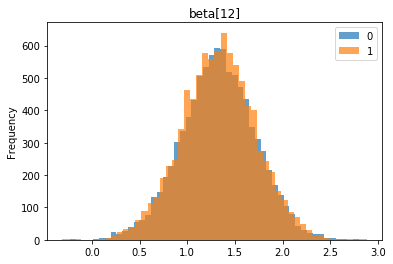

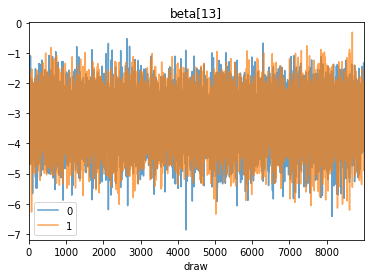

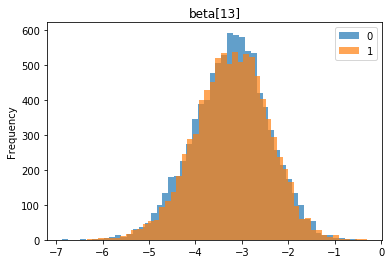

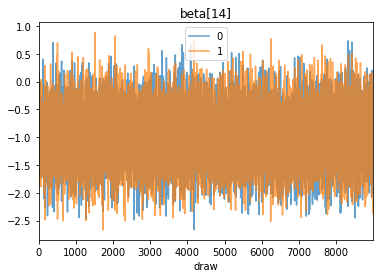

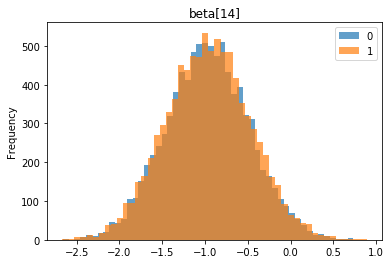

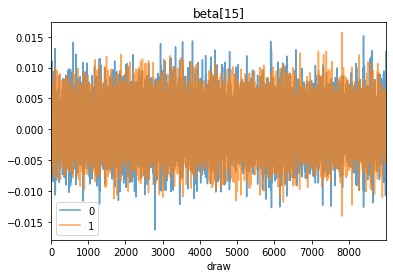

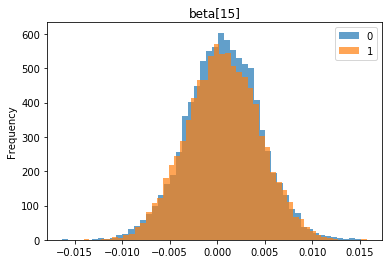

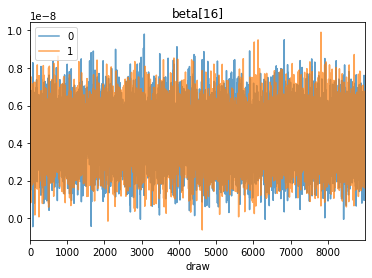

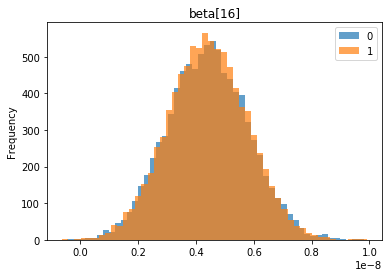

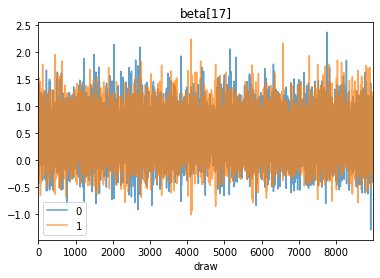

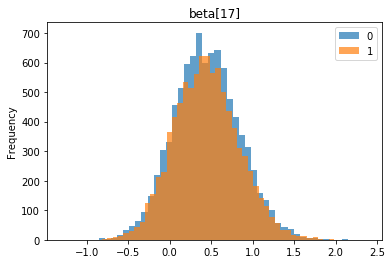

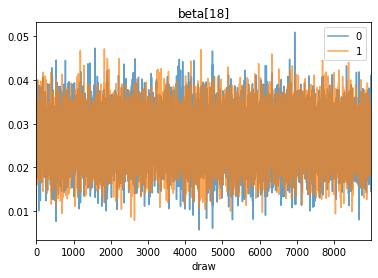

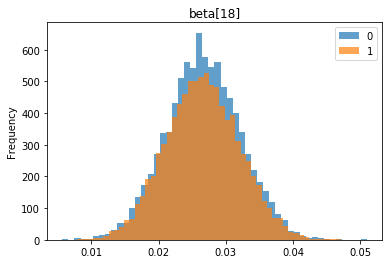

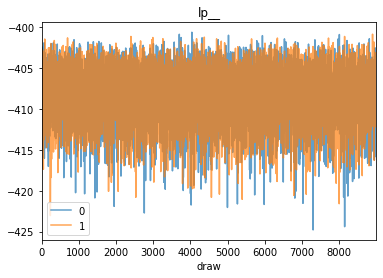

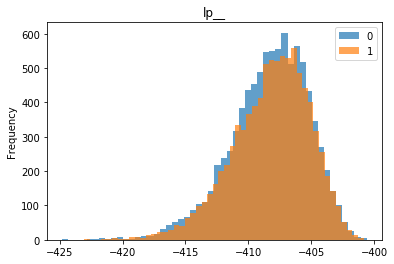

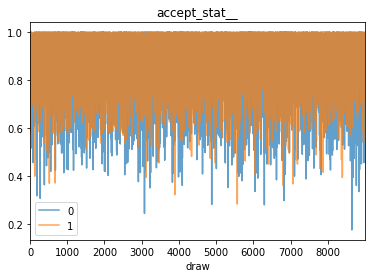

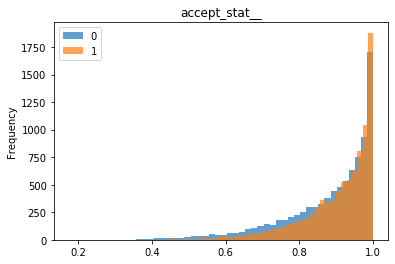

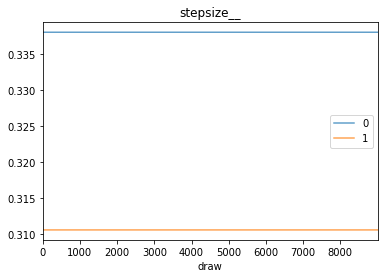

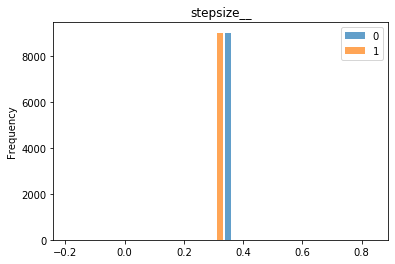

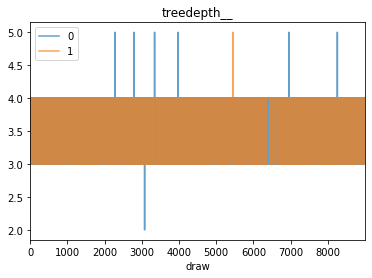

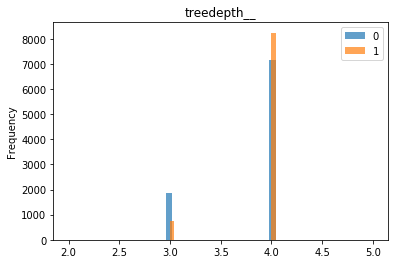

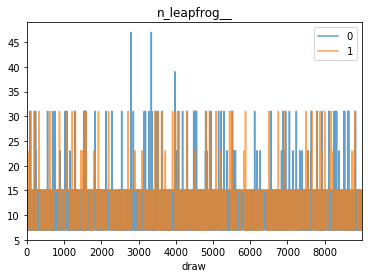

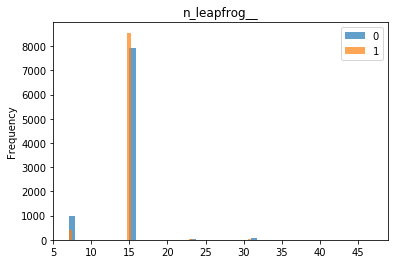

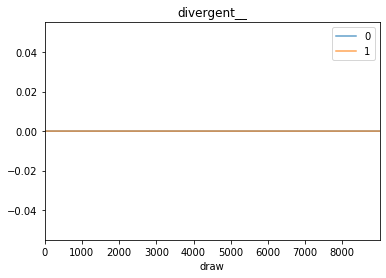

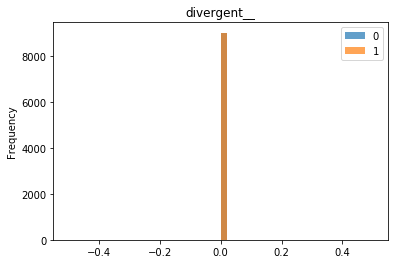

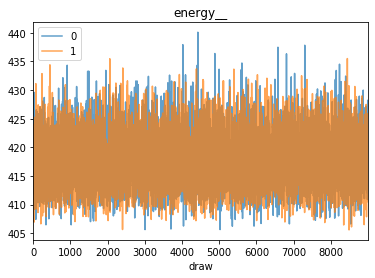

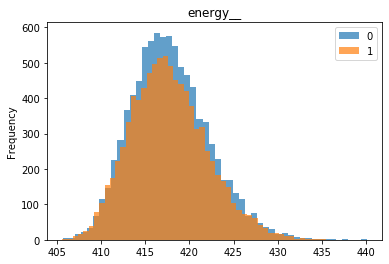

In [20]:
make_plots(logit_fit)